In [69]:
%matplotlib inline
from util.cer_util import CER
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import datetime
import util.theory
from importlib import reload
langau_pdf = reload(util.theory).langau_pdf
plt.style.use(r'./stylesheets/eloss.mplstyle')

Need to define <code>rec_key</code> to be for the reconstruction with the same parameters as those passed into the CER constructor here. This is a problem that needs refactoring in the future. Even with this, check that the energies of the reconstructed muons is equal to the energies of muons in <code>cer.muons</code>. (Due to updates to the selection cuts, this fails for the base reconstructions).

In [24]:
rec_key = 'narrow_lpitch_fs'
cer = CER(full=True, e_lims=(1,10), pitch_lims=(0.3, 0.4), angle_given=False)
cer.load_muons()

Loading Data...
Loaded!
Slimming...
Will remove 131967 particles
There are 2675 muons left to analyze


In [25]:
# Test that the loaded muons are identical to the reconstructed muons
print((cer.muons.backtracked_e - cer.rest_e).to_list() == pd.read_csv(cer.reconstructions[rec_key]).truth.to_list())

False


In [26]:
print(np.abs(pd.read_csv(cer.reconstructions[rec_key]).truth - (cer.muons.backtracked_e - cer.rest_e)).max())

8.933197246801758


For some reason, there is a slight deviation in the true energy tracked by <code>cer.muons</code> and the true energy written to the csv in the narrow energy case. Don't know why this is, but the difference is negligible anyway.

In [27]:
def savefig(fig, name):
    date = datetime.datetime.now()
    month_day = f'{date.month}-{date.day}/'
    path = r'./plots/' + month_day + name
    fig.savefig(path, bbox_inches='tight')
    print(f'Saved to {path}')

In [30]:
def generate_cum_reconstruction(rec_key, mu_idx, delta_rm=True):
    fit_data = pd.read_csv(cer.fits[rec_key])
    dedxs = cer.generate_eloss(mu_idx)[1]
    loglike, dedxs = cer.cum_binned_like(dedxs, rec_key)
    cum_maxs = np.argmax(loglike, axis=0)
    
    true_e = cer.muons.backtracked_e[mu_idx] - cer.rest_e
    correct_bin = np.digitize(true_e, [fit_data['e_min'].iloc[0]] + fit_data['e_max'].to_list()) - 1
    rec_bin = cum_maxs[-1]
    return cum_maxs, dedxs, rec_key, mu_idx, true_e, correct_bin, rec_bin, fit_data
    

In [31]:
def plot_cum_reconstruction(cum_maxs, dedxs, rec_key=None, mu_idx=None, true_e=None, correct_bin=None, rec_bin=None, fit_data=None):
    fig = plt.figure()
    lax = fig.gca()
    line, = lax.plot(cum_maxs, ls='-', c='b')
    lax.set_ylabel('reconstruction bin', color='b')
    lax.set_xlabel('datapoint index along track')
    lax.grid(visible=True, axis='y', color='b', alpha=0.2)

    rax = lax.twinx()
    scat, = rax.plot(dedxs, marker='.', c='r')
    rax.set_ylabel('dedx (MeV/cm)', color='r')
    rax.grid(visible=True, axis='y', color='r', linestyle=':', alpha=0.3)
    
    mu_status = 'Bad'
    if rec_bin==correct_bin:
        mu_status = 'Good'
    
    lax.legend([line, scat], 
               [f"Cumulative Reconstruction", f'dE/dx data'],
               loc='upper center', bbox_to_anchor=(0.5, 1.27), shadow=True, framealpha=1, 
               title=f'{mu_status} Muon (index {mu_idx}), {rec_key} reconstruction\nTrue Muon Energy = {true_e:.2f} GeV (bin {correct_bin})\nReconstructed = ({fit_data.e_min[rec_bin]:.2f}, {fit_data.e_max[rec_bin]:.2f}) GeV (bin {rec_bin})')
    return fig

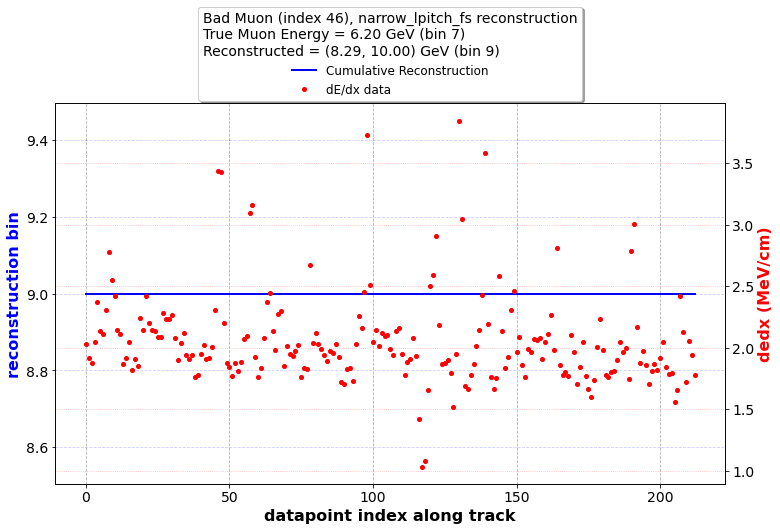

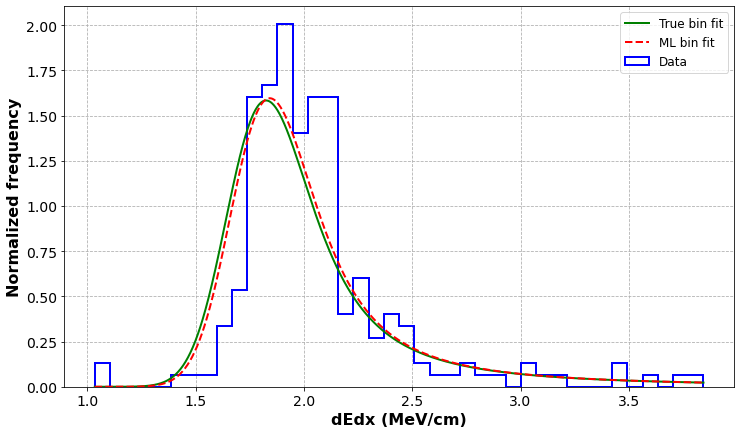

In [84]:
res = generate_cum_reconstruction(rec_key, 46, delta_rm=False)
plot_cum_reconstruction(*res)
plt.show()


dedxs, correct_bin, rec_bin, fit_data = res[1], res[5], res[6], res[7]
params = fit_data[['mpv', 'eta', 'sigma']]
x = np.linspace(np.min(dedxs), np.max(dedxs), 1000)
y_true = langau_pdf(x, *params.iloc[correct_bin])
y_rec = langau_pdf(x, *params.iloc[rec_bin])
plt.figure()
plt.hist(res[1], 40, histtype='step', density=True, linewidth=2, color='b', label='Data')
plt.plot(x, y_true, ls='-', c='g', label='True bin fit')
if correct_bin != rec_bin:
    plt.plot(x, y_rec, ls='--', c='r', label='ML bin fit')
plt.legend()
plt.xlabel("dEdx (MeV/cm)")
plt.ylabel("Normalized frequency")
plt.show()

In [7]:
rec_data = pd.read_csv(cer.reconstructions[rec_key])
correctly_reconstructed = ((rec_data.reconstructed_min < rec_data.truth) & (rec_data.truth < rec_data.reconstructed_max))
good_mu_idxs = rec_data[correctly_reconstructed].index
bad_mu_idxs = rec_data[~correctly_reconstructed].index

In [1]:
%%script false --no-raise-error
rng = np.random.default_rng()
chosen_good_idxs = rng.choice(good_mu_idxs, size=50, replace=False)
chosen_bad_idxs = rng.choice(bad_mu_idxs, size=50, replace=False)

with open('cumulative_likelihoods.dat', 'wb') as file:
    for idx in chosen_good_idxs:
        fig = plot_cum_reconstruction(rec_key, idx)
        savefig(fig, f'good_{rec_key}_cumulative_reconstruction_muon_{idx}.png')
        pickle.dump(fig, file)
        plt.close(fig)
        
    for idx in chosen_bad_idxs:
        fig = plot_cum_reconstruction(rec_key, idx)
        savefig(fig, f'bad_{rec_key}_cumulative_reconstruction_muon_{idx}.png')
        pickle.dump(fig, file)
        plt.close(fig)

The following is specifically for the MC cumulative reconstructions

In [29]:
rec_key = 'mc'
mc_dedxs = pd.read_csv('./data/mc_dedxs.csv')
fit_data = pd.read_csv('./data/fit_data/narrow_lowpitch_fixedsig_fit_data.csv')

In [1]:
%%script false --no-raise-error
for correct_bin in mc_dedxs.columns[1:]:
    for mu_idx, dedxs in enumerate(mc_dedxs[correct_bin]):
        dedxs = np.array([ float(x) for x in dedxs.strip('][').split(', ') ])
        true_e = fit_data[['e_min','e_max']].iloc[int(correct_bin)].mean()
        loglike, dedxs = cer.cum_binned_like(dedxs, rec_key)
        cum_maxs = np.argmax(loglike, axis=0)
        rec_bin = cum_maxs[-1]
        fig = plot_cum_reconstruction(cum_maxs, dedxs, rec_key, mu_idx, true_e, int(correct_bin), rec_bin, fit_data)
        savefig(fig, f'mc_cumulative_reconstruction_muon_({correct_bin}, {mu_idx}).png')
        plt.close(fig)